<a href="https://colab.research.google.com/github/xxfarias/analise-estrategica-vendas/blob/main/analise_de_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este projeto analisa uma base de dados de vendas da "Empresa X" com o objetivo de identificar oportunidades de crescimento para atingir uma meta de aumento de 20% na receita. A análise cobre as dimensões de produtos, clientes, geografia e sazonalidade, culminando num plano de ação estratégico e numa previsão de vendas para os próximos 12 meses.

# Importação de bibliotecas

In [1]:
# --- Bloco de Importações ---

# Módulo para conectar o notebook ao Google Drive e aceder aos ficheiros.
from google.colab import drive

# Biblioteca para manipulação e análise de dados em formato de tabela (DataFrames).
import pandas as pd

# Biblioteca para visualização de dados estatísticos de alto nível.
import seaborn as sns

# Biblioteca principal para criação e customização detalhada de gráficos.
import matplotlib.pyplot as plt

# Classes do Matplotlib para formatação personalizada dos eixos dos gráficos.
from matplotlib.ticker import FuncFormatter, PercentFormatter

# Módulo para funcionalidades relacionadas a calendários (usado para obter os nomes dos meses).
import calendar

# Biblioteca para operações numéricas (usada aqui para criar valores nulos com np.nan).
import numpy as np

# Modelo de Suavização Exponencial para a nossa análise de previsão de séries temporais.
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- Montagem do Google Drive ---
# Executa a montagem do Google Drive no ambiente do Colab para que possamos ler os nossos ficheiros.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Limpeza dos dados

Lendo a tabela e verificando se os dados foram carregados
---

In [2]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Case_Analise_Vendas/CASE_EMPRESA_X.xlsx")
df.head()

,ORDER NUMBER,QUANTITY ORDERED,PRICE EACH,ORDERLINE NUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,CITY,STATE,COUNTRY,TERRITORY,DEALSIZE
0,10107,30,957,2,2871,2/24/2003,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,NYC,NY,USA,NaN,Small
1,10121,34,8135,5,27659,2003-07-05 00:00:00,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,Reims,NaN,France,EMEA,Small
2,10134,41,9474,2,388434,2003-01-07 00:00:00,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,Paris,NaN,France,EMEA,Medium
3,10145,45,8326,6,37467,8/25/2003,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,Pasadena,CA,USA,NaN,Medium
4,10159,49,100,14,520527,2003-10-10 00:00:00,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,San Francisco,CA,USA,NaN,Medium


Raio-X da tabela
---

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ORDER NUMBER      2823 non-null   int64 
 1   QUANTITY ORDERED  2823 non-null   int64 
 2   PRICE EACH        2823 non-null   int64 
 3   ORDERLINE NUMBER  2823 non-null   int64 
 4   SALES             2823 non-null   int64 
 5   ORDERDATE         2823 non-null   object
 6   QTR_ID            2823 non-null   int64 
 7   MONTH_ID          2823 non-null   int64 
 8   YEAR_ID           2823 non-null   int64 
 9   PRODUCTLINE       2823 non-null   object
 10  MSRP              2823 non-null   int64 
 11  PRODUCTCODE       2823 non-null   object
 12  CUSTOMERNAME      2823 non-null   object
 13  CITY              2823 non-null   object
 14  STATE             1337 non-null   object
 15  COUNTRY           2823 non-null   object
 16  TERRITORY         1749 non-null   object
 17  DEALSIZE      

Correção do campo ORDERDATE para o tipo DATE
---

In [4]:
# função to.datetime()
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDER NUMBER      2823 non-null   int64         
 1   QUANTITY ORDERED  2823 non-null   int64         
 2   PRICE EACH        2823 non-null   int64         
 3   ORDERLINE NUMBER  2823 non-null   int64         
 4   SALES             2823 non-null   int64         
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   QTR_ID            2823 non-null   int64         
 7   MONTH_ID          2823 non-null   int64         
 8   YEAR_ID           2823 non-null   int64         
 9   PRODUCTLINE       2823 non-null   object        
 10  MSRP              2823 non-null   int64         
 11  PRODUCTCODE       2823 non-null   object        
 12  CUSTOMERNAME      2823 non-null   object        
 13  CITY              2823 non-null   object        
 14  STATE             1337 n

Verificando valores duplicados
---

In [5]:
# Função .duplicated que retorna True/False para valores duplicados e depois realizando a soma
df.duplicated().sum()

np.int64(0)

Preenchendo valores nulos
---

In [6]:
# função .fillna para preencher valores nulos
df["STATE"] = df["STATE"].fillna('N/A')
df["TERRITORY"] = df["TERRITORY"].fillna('N/A')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDER NUMBER      2823 non-null   int64         
 1   QUANTITY ORDERED  2823 non-null   int64         
 2   PRICE EACH        2823 non-null   int64         
 3   ORDERLINE NUMBER  2823 non-null   int64         
 4   SALES             2823 non-null   int64         
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   QTR_ID            2823 non-null   int64         
 7   MONTH_ID          2823 non-null   int64         
 8   YEAR_ID           2823 non-null   int64         
 9   PRODUCTLINE       2823 non-null   object        
 10  MSRP              2823 non-null   int64         
 11  PRODUCTCODE       2823 non-null   object        
 12  CUSTOMERNAME      2823 non-null   object        
 13  CITY              2823 non-null   object        
 14  STATE             2823 n

Criando o campo data
---

In [7]:
# Reconstruir a data a partir de colunas confiáveis
date_components = {'year': df['YEAR_ID'],
                   'month': df['MONTH_ID'],
                   'day': 1}
df['DATA_CORRIGIDA'] = pd.to_datetime(date_components)

# Usamos a nova coluna de data como nosso índice, em vez da 'ORDERDATE'
df = df.set_index('DATA_CORRIGIDA')

# Analise de produtos mais vendidos

Agrupando as vendas por produto e ordenando de forma decrescente

In [8]:
df.groupby('PRODUCTLINE')['SALES'].sum().sort_values(ascending=False)
# Guardando o resultado numa variável
receita_por_produto = df.groupby('PRODUCTLINE')['SALES'].sum().sort_values(ascending=False)

Criando um gráfico de vendas por produto

In [ ]:
# x=receita_por_produto.values: Coloca os valores numéricos (as vendas) no eixo horizontal.
# y=receita_por_produto.index: Coloca as nossas categorias (os nomes dos produtos) no eixo vertical.
# Função do Seaborn para gráficos de barra sns.barplot(x=, y=)
grafico_vendas_produto = sns.barplot(x=receita_por_produto.values, y=receita_por_produto.index)

# Colocando título e rótulos no gráfico
plt.title('Produtos mais vendidos')
plt.xlabel('Receita Total')
plt.ylabel('Produtos')

# 3. Adicionar os Rótulos de Dados com um Loop
for index, value in enumerate(receita_por_produto.values):
    # O plt.text escreve um texto na posição x, y do gráfico
    # Formatamos o valor para ficar em milhões (ex: $276.8M)
    plt.text(value, index, f' ${value/1e6:,.1f}M')

# Exibe o gráfico final com todas as personalizações
# plt.show()

Gráfico de barras - Produtos mais vendidos
Correção do gráfico, ajustando escala, rótulos e a cor
---



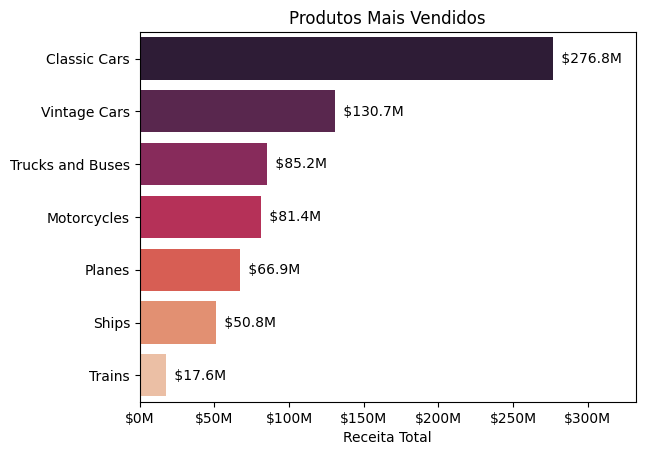

In [10]:
# 1. Criar o gráfico base
sns.barplot(x=receita_por_produto.values, y=receita_por_produto.index, hue=receita_por_produto.index, palette='rocket', legend=False)

# 2. Adicionar Título e Rótulos
plt.title('Produtos Mais Vendidos')
plt.xlabel('Receita Total')
plt.ylabel('')

# 3. Criar uma função para formatar os números em Milhões
def millions_formatter(x, pos):
    return f'${int(x/1e6)}M'

# 4. Aplicar a formatação ao eixo X
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))

# 5. Estender o limite do eixo X AINDA MAIS para garantir o espaço
plt.xlim(right=max(receita_por_produto.values) * 1.2) #  20% de espaço extra

# 6. Adicionar os Rótulos de Dados com um espaçamento inteligente
# Calculamos um pequeno espaçamento com base no valor máximo
padding = max(receita_por_produto.values) * 0.01 # 1% do valor máximo

for index, value in enumerate(receita_por_produto.values):
    # Adicionamos o 'padding' à posição 'x' do texto para "empurrá-lo" para a direita
    plt.text(x=value + padding, y=index, s=f' ${value/1e6:,.1f}M', va='center')

# 7. Exibir o gráfico final
plt.show()

Gráfico de pareto - Produtos mais vendidos
---

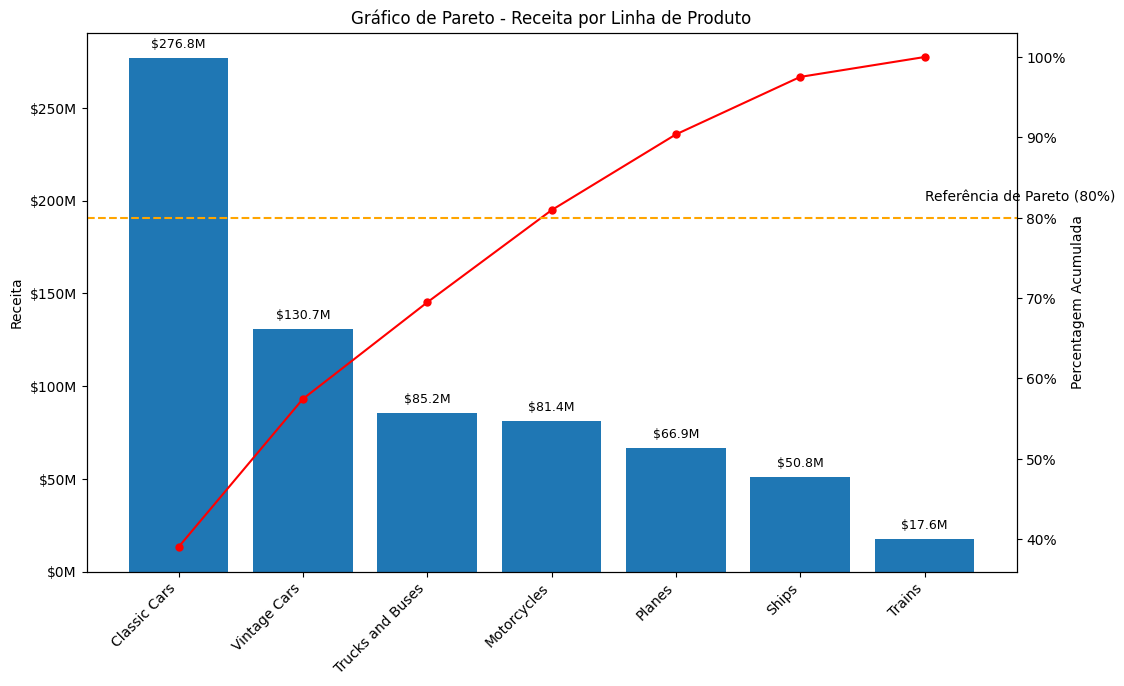

In [11]:
# 1. Preparar os dados
receita_por_produto = df.groupby('PRODUCTLINE')['SALES'].sum().sort_values(ascending=False)
df_pareto = receita_por_produto.to_frame('SALES')
df_pareto['CUMPCT'] = (df_pareto['SALES'].cumsum() / df_pareto['SALES'].sum()) * 100

# 2. Criar a "tela de desenho" e o eixo principal
fig, ax = plt.subplots(figsize=(12, 7))

# 3. Plotar o gráfico de barras
ax.bar(df_pareto.index, df_pareto['SALES'])
plt.xticks(rotation=45, ha='right')

#  4: Formatar o eixo Y principal para milhões
def millions_formatter(x, pos):
    return f'${int(x/1e6)}M'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_ylabel('Receita')

# 5: Adicionar rótulos de dados às barras
padding = max(df_pareto['SALES']) * 0.02 # 2% de padding para o texto não colar na barra
for i, value in enumerate(df_pareto['SALES']):
    ax.text(i, value + padding, f'${value/1e6:,.1f}M', ha='center', fontsize=9)

# 6. Criar e plotar o segundo eixo Y (percentagem)
ax2 = ax.twinx()
ax2.plot(df_pareto.index, df_pareto['CUMPCT'], color='red', marker='o', ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Percentagem Acumulada')

# 7. Manter a linha de 80% como referência padrão
ax2.axhline(80, color='orange', linestyle='--')
ax2.text(len(df_pareto)-1, 82, 'Referência de Pareto (80%)') # Adiciona um texto para a linha

plt.title('Gráfico de Pareto - Receita por Linha de Produto')
plt.show()

Insight: A análise de Pareto confirma uma forte concentração de receita nos produtos. As três principais linhas de produto (Classic Cars, Vintage Cars e Trucks and Buses) são responsáveis por mais de 70% do faturamento total. A linha Classic Cars, sozinha, representa quase 40% de toda a receita, consolidando-se como o motor financeiro da empresa.

Conclusão de Negócio: Qualquer estratégia de crescimento deve começar pela otimização e proteção destes segmentos-chave.

# Analise de maiores clientes

Gráfico de barras - 10 Maiores clientes
---

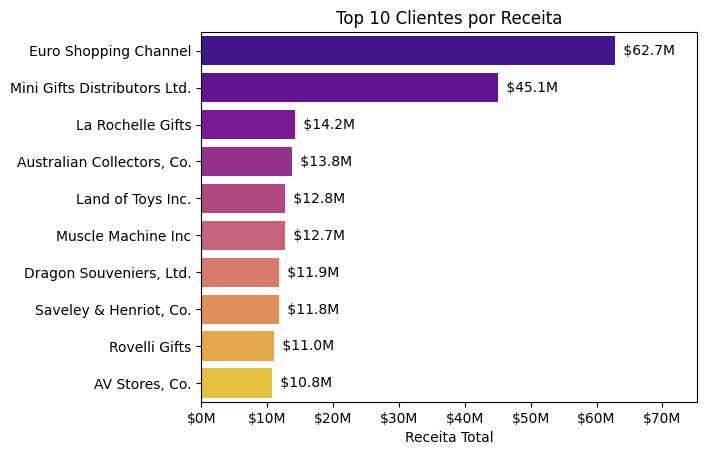

In [12]:
# --- Bloco de Código para o Gráfico de Top 10 Clientes ---

# 1. Agrupamento e seleção
receita_por_cliente = df.groupby('CUSTOMERNAME')['SALES'].sum().sort_values(ascending=False)
top_10_clientes = receita_por_cliente.head(10)

# 2. Criar o gráfico base com o Seaborn e a nova paleta de cores
sns.barplot(x=top_10_clientes.values, y=top_10_clientes.index, hue=top_10_clientes.index, palette='plasma', legend=False)

# 3. Adicionar Título e Rótulos
plt.title('Top 10 Clientes por Receita')
plt.xlabel('Receita Total')
plt.ylabel('')

# 4. Formatar o eixo X em Milhões
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))

# 5. Estender o limite do eixo X para dar espaço aos rótulos
plt.xlim(right=max(top_10_clientes.values) * 1.2)

# 6. Adicionar os Rótulos de Dados com um espaçamento
padding = max(top_10_clientes.values) * 0.01

for index, value in enumerate(top_10_clientes.values):
    plt.text(x=value + padding, y=index, s=f' ${value/1e6:,.1f}M', va='center')

# 7. Exibir o gráfico final
plt.show()

Insight: Assim como nos produtos, a receita é altamente dependente de poucos clientes. Apenas 10 dos 92 clientes da base geram quase 30% de todo o faturamento. Os dois principais parceiros, Euro Shopping Channel e Mini Gifts Distributors Ltd., estão numa categoria própria. A análise também revelou que 62% da receita provêm de negócios de porte "Médio", definindo o nosso perfil de venda ideal.

Conclusão de Negócio: É crucial mitigar o risco desta concentração através de um programa de fidelização para contas-chave (Key Accounts) e focar os esforços de prospecção em clientes com este perfil de compra.

# Analise de países com mais vendas


Gráfico de barras - Paises com mais vendas
---

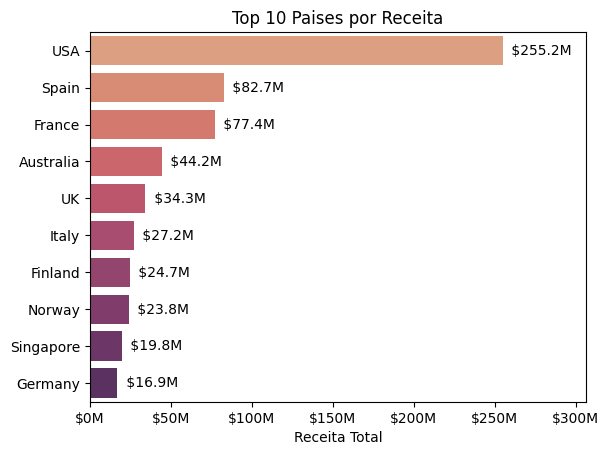

In [13]:
# 1. Agrupamento e seleção
receita_por_pais = df.groupby('COUNTRY')['SALES'].sum().sort_values(ascending=False)
top_10_paises = receita_por_pais.head(10)

# 2. Criar o gráfico base com o Seaborn e a nova paleta de cores
sns.barplot(x=top_10_paises.values, y=top_10_paises.index, hue=top_10_paises.index, palette='flare', legend=False)

# 3. Adicionar Título e Rótulos
plt.title('Top 10 Paises por Receita')
plt.xlabel('Receita Total')
plt.ylabel('')

# 4. Formatar o eixo X em Milhões
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))

# 5. Estender o limite do eixo X para dar espaço aos rótulos
plt.xlim(right=max(top_10_paises.values) * 1.2)

# 6. Adicionar os Rótulos de Dados com um espaçamento
padding = max(top_10_paises.values) * 0.01

for index, value in enumerate(top_10_paises.values):
    plt.text(x=value + padding, y=index, s=f' ${value/1e6:,.1f}M', va='center')

# 7. Exibir o gráfico final
plt.show()

Gráfico de pizza - Paises com mais vendas
---

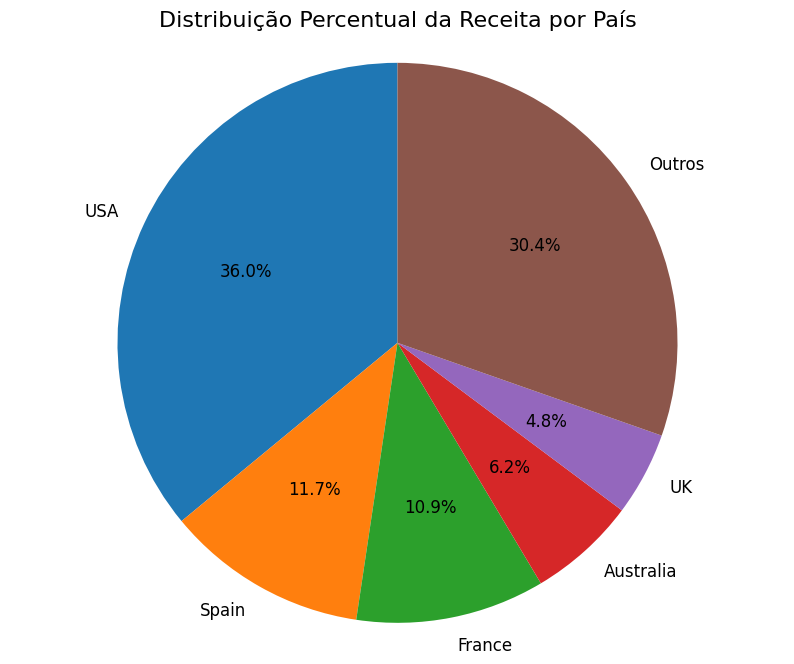

In [14]:
# 1. Calcular a frequência relativa
receita_por_pais = df.groupby('COUNTRY')['SALES'].sum()
frequencia_relativa = (receita_por_pais / df['SALES'].sum()) * 100
frequencia_relativa_ordenada = frequencia_relativa.sort_values(ascending=False)

# 2. Preparar os dados para o gráfico de pizza
# Pegamos os 5 primeiros países
top_5_paises_freq = frequencia_relativa_ordenada.head(5)

# Somamos todos os outros para criar a fatia "Outros"
outros_freq = frequencia_relativa_ordenada.iloc[5:].sum()

# Adicionamos "Outros" à nossa lista
top_5_paises_freq['Outros'] = outros_freq

# 3. Criar o gráfico de pizza com o Matplotlib
plt.figure(figsize=(10, 8)) # Define um bom tamanho para o gráfico
plt.pie(top_5_paises_freq, labels=top_5_paises_freq.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})

# 4. Adicionar um título
plt.title('Distribuição Percentual da Receita por País', fontsize=16)

# 5. Garantir que o gráfico seja um círculo perfeito
plt.axis('equal')

# 6. Exibir o gráfico final
plt.show()

Insight: A presença global da empresa também segue a regra de Pareto. Cerca de 70% de toda a receita vêm de apenas 5 países. Há uma dependência massiva dos EUA, que sozinhos representam mais de 35% do faturamento total, com a Europa (liderada por Espanha e França) a consolidar-se como o segundo mercado mais importante.

Conclusão de Negócio: A estratégia deve ser dupla: proteger e otimizar a liderança nos EUA e usar as parcerias europeias existentes como uma ponte para aprofundar a penetração em mercados com alto potencial, como a Alemanha e o Reino Unido.

# Analise de sazonalidade

Gráfico de linhas - Vendas ao longo do tempo
---

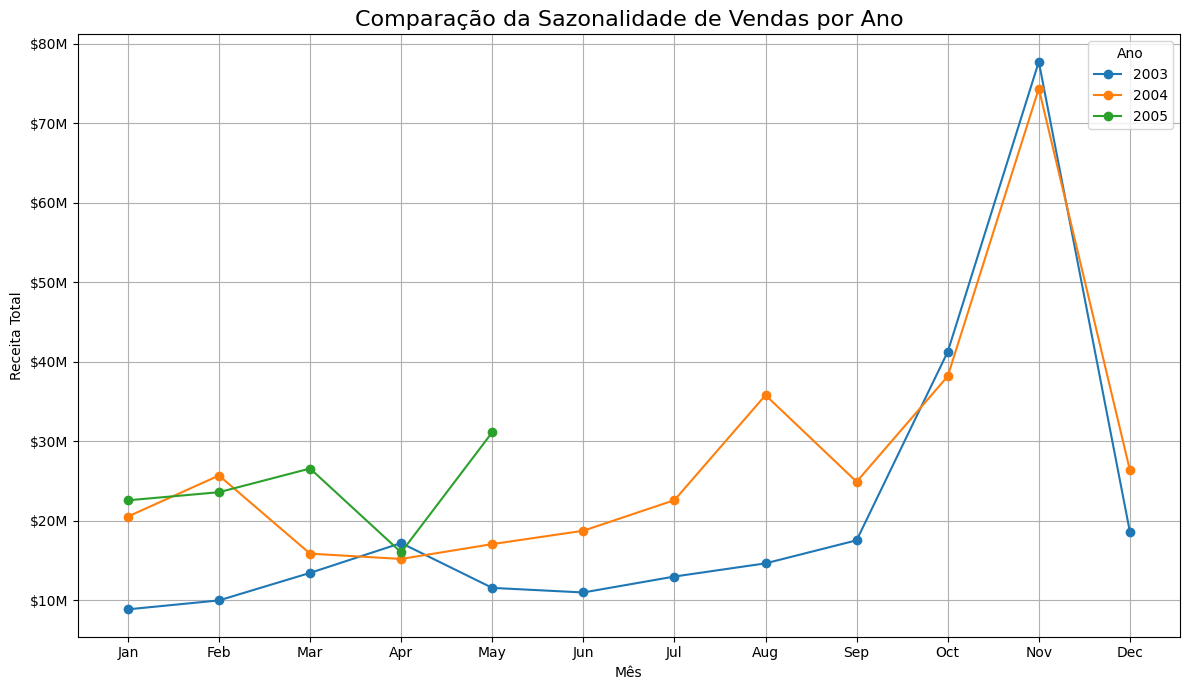

In [15]:
# 1. PREPARAÇÃO DA VISUALIZAÇÃO
# Cria a "tela de desenho" (fig) e a área do gráfico (ax), definindo um tamanho de 12x7 polegadas.
fig, ax = plt.subplots(figsize=(12, 7))

# 2. PLOTAGEM DOS DADOS
# Inicia um loop para passar por cada um dos anos de interesse.
for ano in [2003, 2004, 2005]:
    # Filtra o DataFrame para conter apenas os dados do ano atual do loop.
    dados_do_ano = df[df.index.year == ano]
    # Agrupa os dados do ano por mês ('ME' = Month-End) e soma as vendas.
    vendas_mensais_ano = dados_do_ano['SALES'].resample('ME').sum()
    # Desenha uma linha no gráfico com os meses no eixo X e as vendas no eixo Y.
    ax.plot(vendas_mensais_ano.index.month, vendas_mensais_ano.values, label=ano, marker='o')


# 3. REFINAMENTO E FORMATAÇÃO DO GRÁFICO
# Define o título principal do gráfico.
plt.title('Comparação da Sazonalidade de Vendas por Ano', fontsize=16)
# Define o rótulo do eixo X.
plt.xlabel('Mês')
# Define o rótulo do eixo Y.
plt.ylabel('Receita Total')

# 4. FORMATAÇÃO DOS EIXOS
# Define uma função para formatar um número em uma string de "milhões" (ex: $150M).
def millions_formatter(x, pos):
    return f'${int(x/1e6)}M'
# Aplica a função de formatação ao eixo Y para melhorar a legibilidade.
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Cria uma lista com as abreviações dos meses (ex: 'Jan', 'Fev', 'Mar').
month_names = [calendar.month_abbr[i] for i in range(1, 13)]
# Define os marcadores do eixo X para serem os números dos meses, com os nomes abreviados como rótulos.
plt.xticks(ticks=range(1, 13), labels=month_names)

# 5. TOQUES FINAIS E EXIBIÇÃO
# Adiciona uma legenda ao gráfico, com o título "Ano".
plt.legend(title='Ano')
# Adiciona uma grade de fundo para facilitar a leitura dos valores.
plt.grid(True)
# Ajusta o layout do gráfico para garantir que todos os elementos (títulos, rótulos) caibam sem sobreposição.
plt.tight_layout()
# Exibe o gráfico final.
plt.show()

Insight: O gráfico revela um padrão sazonal muito claro e repetível. As vendas disparam massivamente no último trimestre, com um pico em Outubro e Novembro, período que define o sucesso do ano fiscal. Os meses de meio de ano (especialmente Julho) representam os pontos mais baixos de vendas.

Conclusão de Negócio: O planeamento de estoque e as campanhas de marketing devem ser totalmente orientados por esta sazonalidade, antecipando a procura do final do ano e criando iniciativas para estimular as vendas nos meses de baixa.

# Previsão de vendas

Suavização Exponencial de vendas

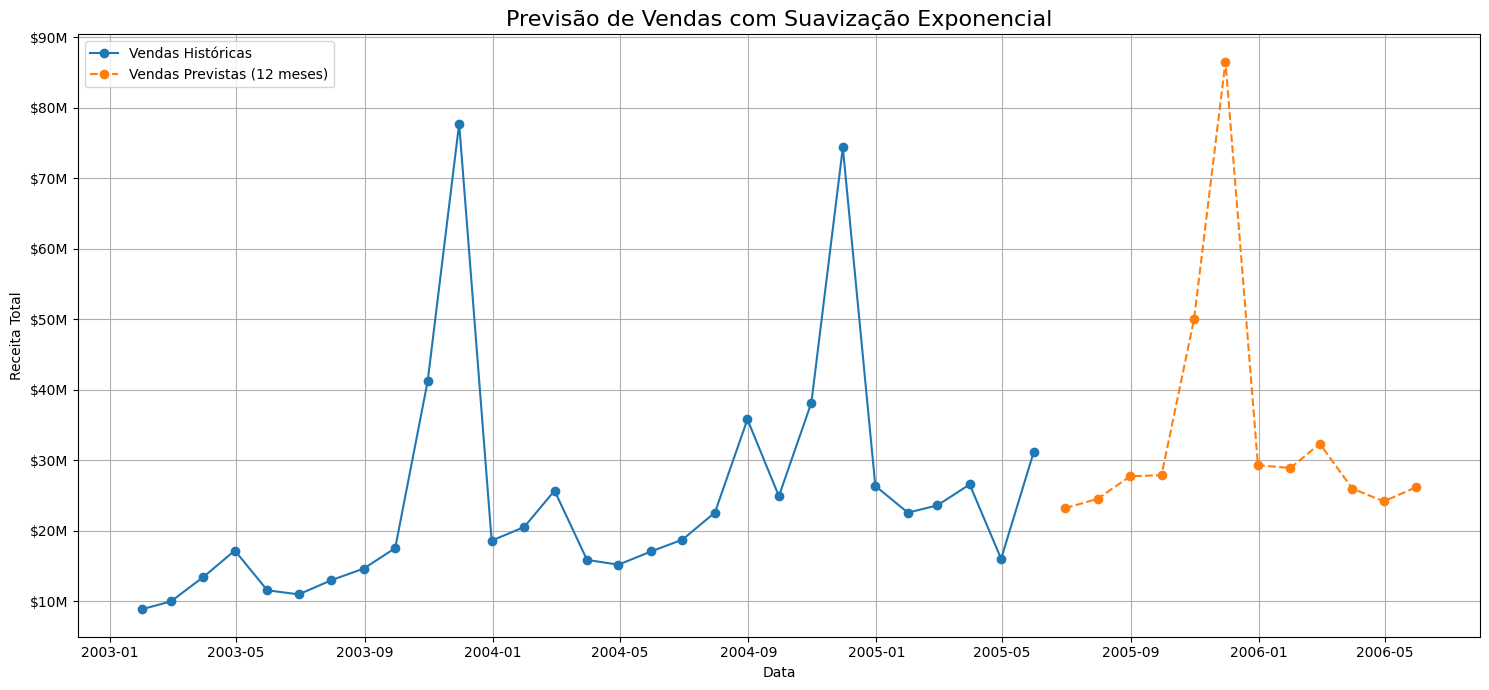

In [16]:
# 1. PREPARAÇÃO DOS DADOS PARA O MODELO
# Criar a série temporal com as vendas totais por mês.
vendas_mensais = df['SALES'].resample('ME').sum()

# 2. CONSTRUÇÃO E TREINO DO MODELO
# Criar o modelo de Suavização Exponencial (Holt-Winters)
# trend='add' -> a tendência cresce ou diminui de forma linear.
# seasonal='add' -> a sazonalidade tem uma amplitude constante.
# seasonal_periods=12 -> o padrão sazonal repete-se a cada 12 meses.
modelo = ExponentialSmoothing(vendas_mensais, trend='add', seasonal='add', seasonal_periods=12)

# Treinar o modelo com os nossos dados históricos.
modelo_treinado = modelo.fit()

# 3. GERAR A PREVISÃO
# Pedir ao modelo treinado para prever os próximos 12 meses.
previsao_12_meses = modelo_treinado.forecast(12)

# 4. VISUALIZAÇÃO DOS RESULTADOS
# Definir um bom tamanho para a figura.
plt.figure(figsize=(15, 7))

# Plotar os dados históricos (a nossa realidade).
plt.plot(vendas_mensais.index, vendas_mensais.values, label='Vendas Históricas', marker='o')

# Plotar os dados previstos (o nosso futuro projetado).
plt.plot(previsao_12_meses.index, previsao_12_meses.values, label='Vendas Previstas (12 meses)', linestyle='--', marker='o')

# 5. REFINAMENTO DO GRÁFICO
# Adicionar Título e Rótulos.
plt.title('Previsão de Vendas com Suavização Exponencial', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Receita Total')

# Reutilizar a nossa função de formatação para o eixo Y.
def millions_formatter(x, pos):
    return f'${int(x/1e6)}M'
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Adicionar legenda e grade.
plt.legend()
plt.grid(True)
plt.tight_layout()

# Exibir o gráfico final.
plt.show()

Insight: O modelo de previsão (Suavização Exponencial) projeta uma continuação da forte tendência sazonal para os próximos 12 meses, com um pico de vendas esperado para o final do ano. A previsão indica um crescimento orgânico contínuo se as tendências atuais se mantiverem.

Conclusão de Negócio: Esta previsão serve como a nossa linha de base. O plano de ação estratégico proposto visa não apenas acompanhar, mas acelerar este crescimento previsto para garantir que a meta de 20% seja superada.

# Conclusão

A análise revelou que a receita da empresa é altamente concentrada. Com base nisso, o plano de ação recomendado foca-se em três pilares:

1. Otimização dos Produtos-Chave,
2. Fidelização dos Clientes VIP,
3. Expansão Geográfica Inteligente.

A previsão de vendas indica uma tendência de crescimento que, se acelerada por estas iniciativas, tem o potencial de atingir e superar a meta de 20%.